<h1 style = "color:navy">Potato disease classification</h1>

### Libraries import :

In [1]:
import tensorflow as tf 
from tensorflow.keras import models , layers 
import matplotlib.pyplot as plt 

### Loading data from tf utils : 

In [2]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3 
EPOCHS = 25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '../dataset/',
    shuffle = True ,
    image_size = ( IMAGE_SIZE , IMAGE_SIZE ) ,
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


*Getting classes names :*

In [4]:
class_names = dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### *Data visualization:*

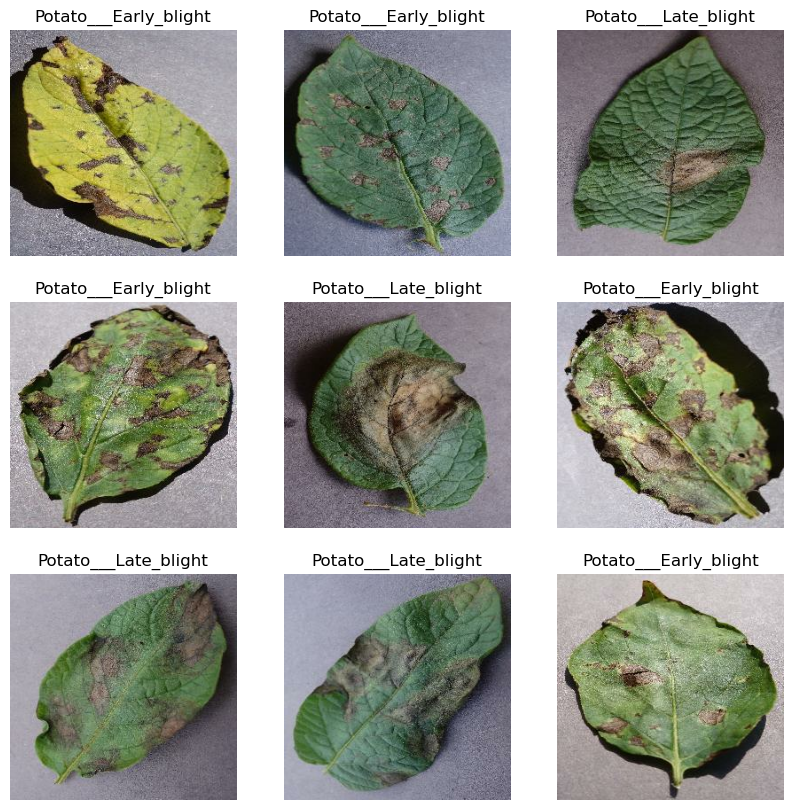

In [5]:
plt.figure ( figsize = ( 10 , 10 ) ) 

for image_batch , image_label in dataset.take ( 1 ) :
    
    for i in range ( 9 ) : 
        ax = plt.subplot ( 3 , 3 , i+1 ) 
        ax.imshow ( image_batch [i].numpy().astype ( 'uint8' ) ) 
        plt.title ( class_names [ image_label [ i ] ] ) 
        plt.axis ( 'off' ) 

Dataset length : 

In [6]:
len ( dataset ) 

68

the dataset is divided into 32 batches of 68 elements each , which makes 32*68=2176 images

Splitting dataset into train , validation and test samples : 

* train%== 80
* val%== 10
* test%== 10

Training sample :

In [7]:
len ( dataset )*0.8

54.400000000000006

About samples for training : 

In [8]:
training_dataset = dataset.take ( 54 )
len ( training_dataset )

54

Validation sample : 

In [9]:
val_test = dataset.skip ( 54 )

In [10]:
len ( val_test ) 

14

In [11]:
len ( dataset ) * 0.1

6.800000000000001

In [12]:
validation_dataset = val_test.take ( 6 ) 

In [13]:
len ( validation_dataset )

6

In [14]:
test_dataset = val_test.skip ( 6 ) 

In [15]:
len ( test_dataset ) 

8

Function to get dataset partition : 

In [16]:
def get_dataset_partitions ( dataset , train_split = 0.8 , validation_split = 0.1 , test_split = 0.1 ,shuffle = True , shuffle_size=1000 ) : 
    
    if shuffle : 
        dataset.shuffle ( shuffle_size , seed = 12 ) 
        
    train_size = int ( len ( dataset ) * train_split ) 
    validation_size = int ( len ( dataset ) * validation_split )
    
    train_dataset = dataset.take ( train_size ) 
    validation_dataset = dataset.skip ( len ( train_dataset ) ).take ( validation_size ) 
    test_dataset = dataset.skip ( len ( train_dataset ) ).skip ( len( validation_dataset ) )
    
    return train_dataset , validation_dataset , test_dataset 

In [17]:
train_dataset , validation_dataset , test_dataset = get_dataset_partitions ( dataset )

In [18]:
len ( train_dataset ) 

54

In [19]:
len ( validation_dataset ) 

6

In [20]:
len ( test_dataset ) 

8

### Caching the datasets : 

In [21]:
train_dataset = train_dataset.cache().shuffle ( 1000 ).prefetch( buffer_size = tf.data.AUTOTUNE ) 
validatoin_dataset = validation_dataset.cache().shuffle ( 1000 ).prefetch ( buffer_size = tf.data.AUTOTUNE ) 
test_dataset = test_dataset.cache().shuffle ( 1000 ).prefetch( buffer_size = tf.data.AUTOTUNE ) 

### Preprocessing data : 

Layer for resizing and rescaling images :

In [22]:
resize_and_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing ( IMAGE_SIZE , IMAGE_SIZE ) ,
    layers.experimental.preprocessing.Rescaling ( 1.0/255 )
])

Layer for data augmentation 

In [23]:
data_augmentation_layer = tf.keras.Sequential ([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical") , 
    layers.experimental.preprocessing.RandomRotation ( 0.2 ) 
])

### Building and training the model : 

In [24]:
INPUT_SHAPE = ( BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS ) 

In [25]:
n_classes =len ( dataset.class_names)
n_classes

3

In [26]:
model = models.Sequential([
    # preprocessing layers 
    resize_and_rescale_layer, 
    data_augmentation_layer,
    # other layers 
    layers.Conv2D( 32 , ( 3 , 3 ) , activation = 'relu' , input_shape = INPUT_SHAPE ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Conv2D( 64 , ( 3 , 3 ) , activation = 'relu' ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Conv2D( 64 , ( 3 , 3 ) , activation = 'relu' ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Conv2D( 64 , ( 3 , 3 ) , activation = 'relu' ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Conv2D( 64 , ( 3 , 3 ) , activation = 'relu' ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Conv2D( 64 , ( 3 , 3 ) , activation = 'relu' ) , 
    layers.MaxPooling2D ( ( 2 , 2 ) ) ,
    layers.Flatten() , 
    layers.Dense ( 64 , activation = 'relu' ) ,
    layers.Dense ( n_classes, activation = 'softmax' )
    
])

In [27]:
model.build ( input_shape = INPUT_SHAPE ) 

In [28]:
model.summary () 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [29]:
model.compile (
    optimizer = 'adam' , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits  = False ) , 
    metrics = ['accuracy']
)

In [30]:
history = model.fit (
    training_dataset , 
    validation_data = validation_dataset ,
    epochs = EPOCHS , 
    batch_size = BATCH_SIZE , 
    verbose = 1 
)

Epoch 1/25


54/54 [==============================] - 149s 3s/step - loss: 0.8659 - accuracy: 0.5590 - val_loss: 0.7446 - val_accuracy: 0.6615
Epoch 2/25
54/54 [==============================] - 121s 2s/step - loss: 0.6341 - accuracy: 0.7292 - val_loss: 0.5323 - val_accuracy: 0.7604
Epoch 3/25
54/54 [==============================] - 125s 2s/step - loss: 0.4993 - accuracy: 0.7726 - val_loss: 0.3260 - val_accuracy: 0.9115
Epoch 4/25
54/54 [==============================] - 129s 2s/step - loss: 0.3214 - accuracy: 0.8588 - val_loss: 0.2630 - val_accuracy: 0.9167
Epoch 5/25
54/54 [==============================] - 162s 3s/step - loss: 0.2630 - accuracy: 0.8947 - val_loss: 0.1438 - val_accuracy: 0.9531
Epoch 6/25
54/54 [==============================] - 181s 3s/step - loss: 0.3028 - accuracy: 0.8796 - val_loss: 0.2152 - val_accuracy: 0.9167
Epoch 7/25
54/54 [==============================] - 187s 3s/step - loss: 0.1868 - accuracy: 0.9271 - val_loss: 0.2270 - val_accuracy: 0.9062
Epoch 8/25


### Model evaluation : 

In [31]:
scores = model.evaluate ( test_dataset ) 

8/8 [==============================] - 5s 382ms/step - loss: 0.0669 - accuracy: 0.9741


In [32]:
print (f"Loss : {scores[0]} \nAccurary : {scores[1]}")

Loss : 0.06685348600149155 
Accurary : 0.9741379022598267


#### Training-Validation accuracy | Train-Validation loss 

In [33]:
accuracy = history.history ['accuracy']
validation_accuracy = history.history ['val_accuracy']

training_loss = history.history ['loss']
validation_loss = history.history ['val_loss']

[]

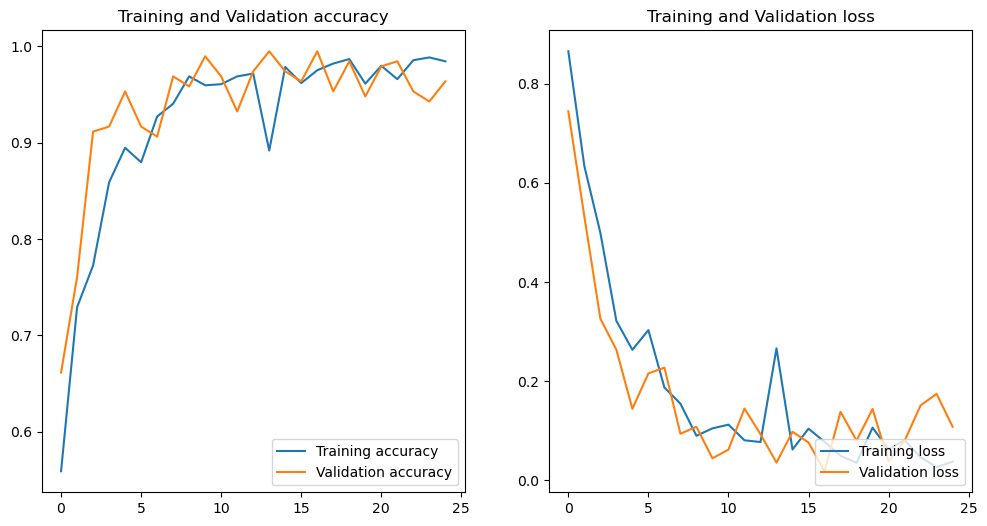

In [34]:
plt.figure ( figsize = ( 12 , 6 ) ) 

plt.subplot ( 1 , 2 , 1 ) 
plt.plot ( range ( EPOCHS ) , accuracy , label = 'Training accuracy' ) 
plt.plot ( range ( EPOCHS ) , validation_accuracy , label = 'Validation accuracy' ) 

plt.legend ( loc = 'lower right' ) 
plt.title ( 'Training and Validation accuracy' ) 

plt.subplot ( 1 , 2 , 2 ) 
plt.plot ( range ( EPOCHS ) , training_loss , label = 'Training loss' ) 
plt.plot ( range ( EPOCHS ) , validation_loss , label = 'Validation loss' ) 

plt.legend ( loc = 'lower right' ) 
plt.title ( 'Training and Validation loss' ) 

plt.plot()


Prediction function : 

In [35]:
import numpy as np 

def predict ( model , image ) : 
    
    img_array = tf.keras.preprocessing.image.img_to_array ( images[i].numpy () ) 
    
    img_array = tf.expand_dims ( img_array , 0 ) 
    
    predictions = model.predict ( img_array ) 
    predicted_class = class_names [np.argmax ( predictions[0])]
    
    confidence = round ( 100 * ( np.max ( predictions [0])))
    
    return predicted_class , confidence 

#### Testing the model : 

1/1 [==============================] - 0s 47ms/step


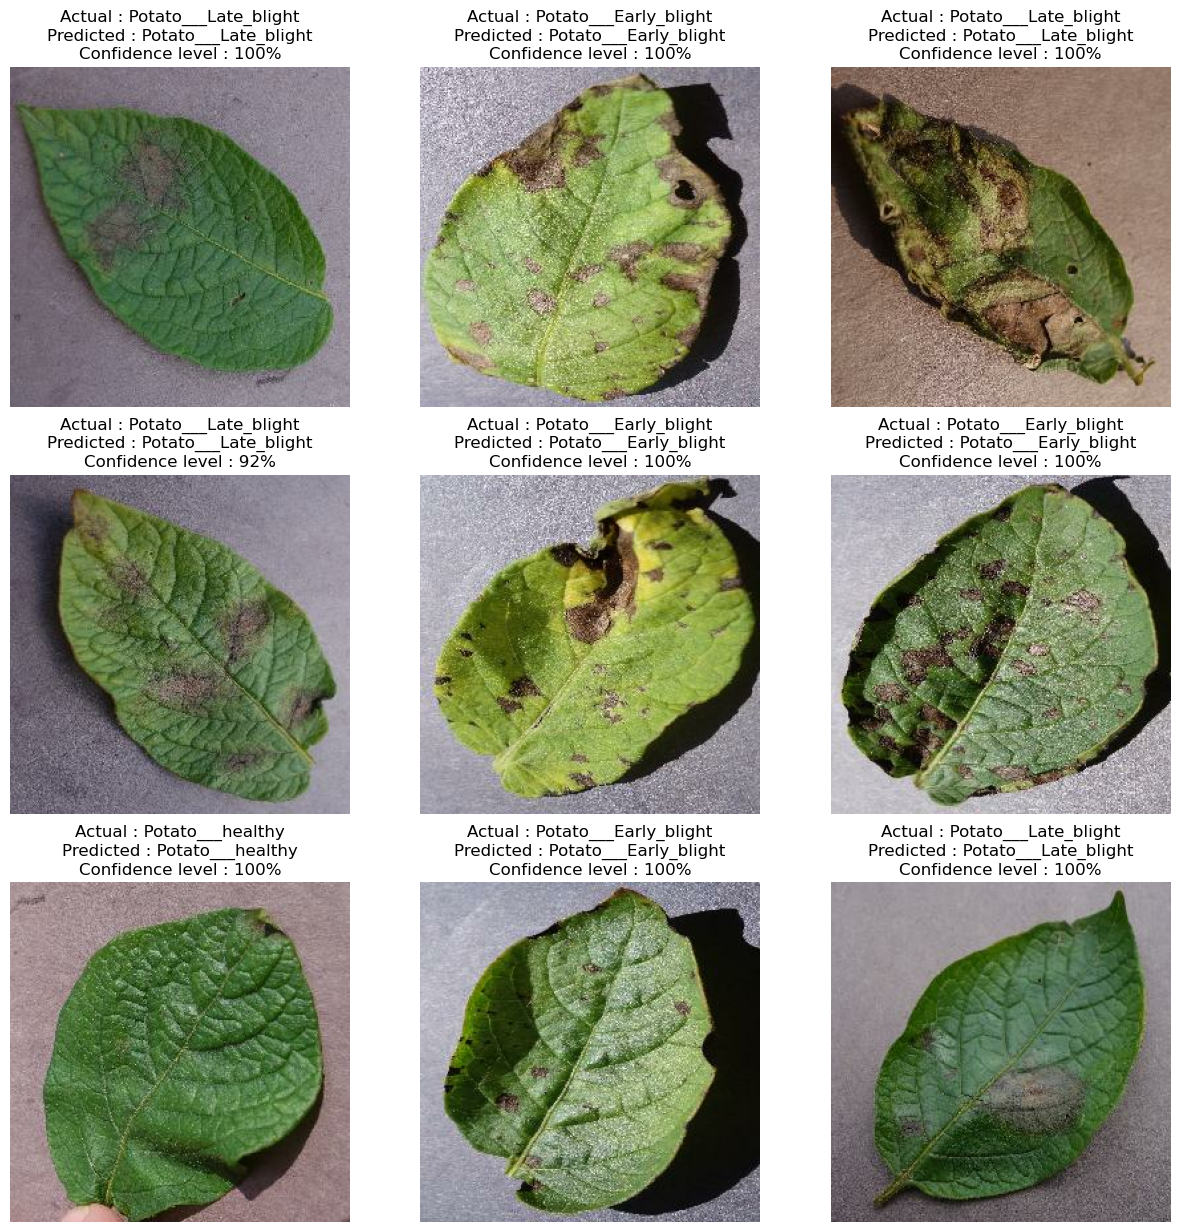

In [36]:
plt.figure ( figsize = ( 15 , 15 ))

for images , labels in test_dataset.take (1) : 
    for i in range ( 9 ) : 
        ax = plt.subplot ( 3 , 3 , i+1 ) 
        plt.imshow ( images [i].numpy ().astype ( 'uint8') ) 
        
        predicted_class , confidence = predict ( model , images[i].numpy () )
        actual_class = class_names [labels[i]]
        
        plt.title (f"Actual : {actual_class}\nPredicted : {predicted_class}\nConfidence level : {confidence}%")
        plt.axis ( 'off' ) 

## Saving the model : 

In [37]:
model_version = 1 
model.save ( f"../saved_models/{model_version}/potato_disease_prediction.keras")

In [41]:
print ( tf.__version__ )
import keras 
print ( keras.__version__ )

2.15.0
2.15.0
